# 再解析データ

再解析データとは，比較的新しい予報モデルに対して過去の観測データを同化したものです。
数値天気予報においては，予報モデルに対して観測がデータ同化した解析値が作成され，初期値として用いられています。
予報モデルは改良が重ねられていくため，解析値の品質はモデルの変遷と共に変化していきます。
データ同化手法も大きく進歩し，数十年前とは全く異なる手法が用いられています。
モデルやデータ同化手法の改良の影響を取り除くことにより，時間的により品質が安定したデータセットになります。
再解析とは，現業予報で一度行った解析を再びやり直すということを意味しています。

:::{caution}
衛星データは世代間のセンサの品質の差やセンサの経年劣化が考慮されていますが，解析値は入力される観測データの種類や量にも解析値は影響を受けます。
品質を一貫させるため，大きな精度向上をもたらす衛星データを使わず従来型観測のみを同化したデータセット（JRA-55C{cite}`Kobayashi_etal_2014`，ERA-20C {cite}`Poli_etal_2016`，20CRv3{cite}`Silvinski_etal_2021`）
が作られています。
:::

本書ではサイズが小さく入手が容易なNCEP/NCAR再解析{cite}`Kalnay_etal_1996`を用います。
NCEP/NCAR再解析は，京都大学生存圏研究所[グローバル大気観測データ](http://database.rish.kyoto-u.ac.jp/arch/glob-atmos/)や米国国立大気研究センター（NCAR）[研究データアーカイブ](https://rda.ucar.edu/)等から入手可能です。

:::{note}
より新しい再解析データセットとして3つあげておきます。

- JRA-55{cite}`Kobayashi_etal_2015`: 気象庁が作成した長期再解析。より長期のデータセット作成中でJRA-3Qが近日完了予定。
- MERRA-2{cite}`Geralo_etal_2017`: NASAによる衛星データを駆使した再解析
- ERA-5{cite}`Hersbach_etal_2020`: 精度に定評があるECMWFが作成したデータセット。積雪深が過大{cite}`Orsolini_etal_2019`
:::


In [1]:
!curl -O http://database.rish.kyoto-u.ac.jp/arch/ncep/data/ncep.reanalysis.derived/surface/slp.mon.mean.nc

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 19.3M  100 19.3M    0     0  63.3M      0 --:--:-- --:--:-- --:--:-- 63.1M


In [3]:
import xarray as xr


ds = xr.open_dataset("slp.mon.mean.nc")

In [24]:
ds

<xarray.Dataset>
Dimensions:  (lat: 73, lon: 144, time: 883)
Coordinates:
  * lat      (lat) float32 90.0 87.5 85.0 82.5 80.0 ... -82.5 -85.0 -87.5 -90.0
  * lon      (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * time     (time) datetime64[ns] 1948-01-01 1948-02-01 ... 2021-07-01
Data variables:
    slp      (time, lat, lon) float32 ...
Attributes:
    description:    Data is from NMC initialized reanalysis\n(4x/day).  These...
    platform:       Model
    Conventions:    COARDS
    NCO:            20121012
    history:        Thu May  4 18:12:35 2000: ncrcat -d time,0,622 /Datasets/...
    title:          monthly mean slp from the NCEP Reanalysis
    dataset_title:  NCEP-NCAR Reanalysis 1
    References:     http://www.psl.noaa.gov/data/gridded/data.ncep.reanalysis...

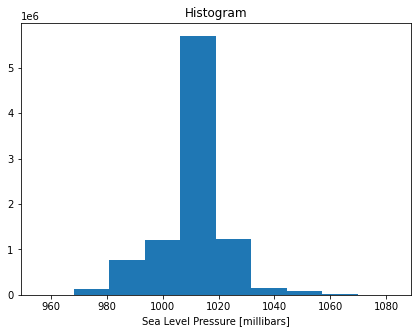

In [141]:
ds.slp.plot(figsize=[7,5])
plt.show()

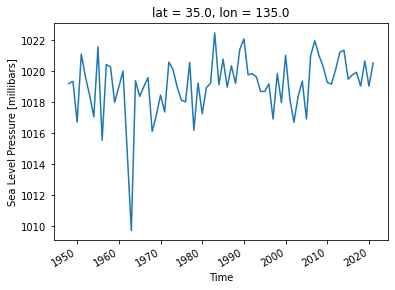

In [30]:
ds.slp.sel(lon=135, lat=35)[0::12].plot()

In [106]:
import matplotlib.pyplot as plt
from cartopy.util import add_cyclic_point

wdata, wlon = add_cyclic_point(ds.slp.sel(time="2021-01")[0], ds.lon)
slp = xr.DataArray(wdata, dims=["lat", "lon"], coords=dict(lat=ds.lat, lon=wlon))

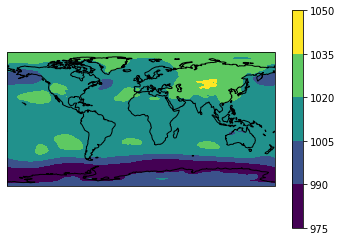

In [120]:
p = slp.plot.contourf(
    subplot_kws = dict(projection=ccrs.PlateCarree()),
    transform=ccrs.PlateCarree()
)
p.axes.set_global()
p.axes.coastlines()

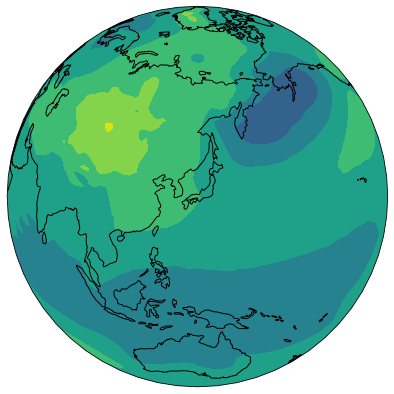

In [135]:
fig = plt.figure(figsize=[7,7])
ax = fig.add_subplot(111, projection=ccrs.Orthographic(135,35))

p = ax.contourf(wlon, ds.lat, slp.data, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_global()
plt.show()

In [129]:
slp

<xarray.DataArray (lat: 73, lon: 145)>
array([[1026.4081 , 1026.4081 , 1026.4081 , ..., 1026.4081 , 1026.4081 ,
        1026.4081 ],
       [1024.7194 , 1024.813  , 1024.917  , ..., 1024.5411 , 1024.6322 ,
        1024.7194 ],
       [1022.01294, 1022.0548 , 1022.1032 , ..., 1021.9429 , 1021.979  ,
        1022.01294],
       ...,
       [ 995.72327,  995.67004,  995.6211 , ...,  995.8042 ,  995.76776,
         995.72327],
       [ 996.07184,  996.03375,  995.9944 , ...,  996.11536,  996.1057 ,
         996.07184],
       [ 995.6226 ,  995.6226 ,  995.6226 , ...,  995.6226 ,  995.6226 ,
         995.6226 ]], dtype=float32)
Coordinates:
  * lat      (lat) float32 90.0 87.5 85.0 82.5 80.0 ... -82.5 -85.0 -87.5 -90.0
  * lon      (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 352.5 355.0 357.5 360.0

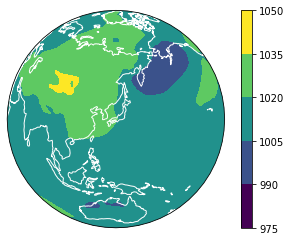

In [103]:
p = slp.plot.contourf(
    subplot_kws = dict(
        projection = ccrs.Orthographic(135,35),
    ),
    transform = ccrs.PlateCarree(),
)
p.axes.coastlines(color="white")
#p.axes.set_extent([0, 359, 20, 90], ccrs.PlateCarree())
p.axes.set_global()
plt.show()